In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [22]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from today
query_date = dt.date(2017,12,1) - dt.timedelta(days=365)
print("Query Date: ", query_date)

Query Date:  2016-12-01


In [23]:
# Perform a query to retrieve the data and precipitation scores
data_12m = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= query_date).all()

In [28]:
# Save the query results as a Pandas DataFrame and set the index to the date column
data_df = pd.DataFrame(data_12m, columns=['date', 'precipitation'])
data_df.set_index(data_df['date'], inplace=True)
data_df.head()

,date,precipitation
date,,
2016-12-01,2016-12-01,0.12
2016-12-02,2016-12-02,0.03
2016-12-03,2016-12-03,0.00
2016-12-04,2016-12-04,0.03
2016-12-05,2016-12-05,0.43


In [26]:
# Sort the dataframe by date
data_df = data_df.sort_values("date")

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'date' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  


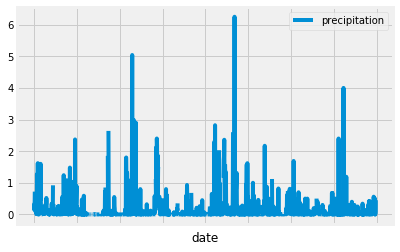

In [27]:
# Use Pandas Plotting with Matplotlib to plot the data
data_df.plot(x_compat=True)

In [29]:
# Use Pandas to calcualte the summary statistics for the precipitation data
data_df.describe()

,precipitation
count,1445.000000
mean,0.170062
std,0.441790
min,0.000000
25%,0.000000
50%,0.010000
75%,0.120000
max,6.250000


In [30]:
# How many stations are available in this dataset?
session.query(func.count(Station.station)).all()

[(9)]

In [35]:
# What are the most active stations?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [36]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

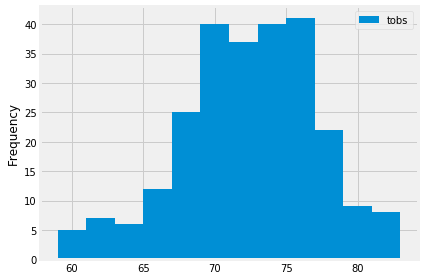

In [39]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
data_df = session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= query_date).all()
data_df = pd.DataFrame(data_df, columns=['tobs'])
data_df.plot.hist(bins=12)
plt.tight_layout()

In [43]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), \
        func.max(Measurement.tobs)).filter(Measurement.date >= start_date).\
        filter(Measurement.date <= end_date).all()
print(calc_temps('2016-12-01', '2017-12-01'))

[(58.0, 73.76643706950533, 87.0)]


In [47]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
prev_year_start = dt.date(2016, 12, 1) - dt.timedelta(days=365)
prev_year_end = dt.date(2017, 12, 1) - dt.timedelta(days=365)

[tmin, tavg, tmax] = calc_temps(prev_year_start.strftime("%Y-%m-%d"), prev_year_end.strftime("%Y-%m-%d"))[0]
print(tmin, tavg, tmax)

56.0 74.34901960784313 84.0


/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


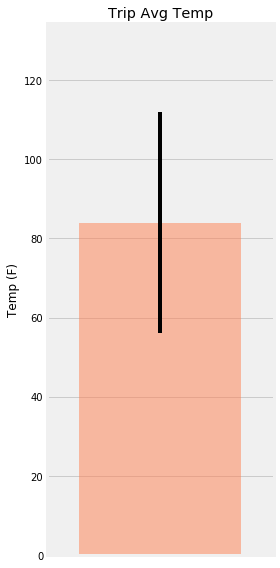

In [48]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots(figsize=plt.figaspect(2.))
xpos = 1
yerr = tmax-tmin

bar = ax.bar(xpos, tmax, yerr=yerr, alpha=0.5, color='coral', align="center")
ax.set(xticks=range(xpos), xticklabels="a", title="Trip Avg Temp", ylabel="Temp (F)")
ax.margins(.2, .2)
# fig.autofmt_xdate()
fig.tight_layout()
fig.show()

In [49]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

start_date = '2016-12-01'
end_date = '2017-12-01'

sel = [Station.station, Station.name, Station.latitude, 
       Station.longitude, Station.elevation, func.sum(Measurement.prcp)]

results = session.query(*sel).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= end_date).\
    group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()
print(results)

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 85.69), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 50.170000000000016), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 39.010000000000055), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 29.599999999999994), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 25.12000000000002), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 12.409999999999995), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 3.7399999999999998)]
